## TO DO:

* Working on the CPU with a reseaonable numbr of statistics try to plot the figure 9.


In [1]:
import numpy as np 
import pandas as pd
import time
import tqdm

In [2]:
import torch
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [3]:
import torch

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")

    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)
    print(f"Current GPU: {current_gpu}")
else:
    print("CUDA is not available. PyTorch is running on CPU.")


Number of available GPUs: 1
Current GPU: Tesla T4


In [4]:
device = "cuda"

In [5]:
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

#Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [6]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

In [7]:
NUM_CLASSES

6

## Model 

In [8]:
import torch
from torch import nn
import torch.nn.functional as nnF

from torch import Tensor
from typing import Optional, Tuple

class QuantizeableMultiheadAttention(nn.MultiheadAttention):
    _FLOAT_MODULE = nn.MultiheadAttention

    r"""Quantizable implementation of the MultiheadAttention.

    Note::
        Please, refer to :class:`~torch.nn.MultiheadAttention` for more
        information

    Allows the model to jointly attend to information from different
    representation subspaces.
    See reference: Attention Is All You Need

    The original MHA module is not quantizable.
    This reimplements it by explicitly instantiating the linear layers.

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).

    Note that if :attr:`kdim` and :attr:`vdim` are None, they will be set
    to :attr:`embed_dim` such that query, key, and value have the same
    number of features.

    Examples::

        >>> import torch.ao.nn.quantizable as nnqa
        >>> multihead_attn = nnqa.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)

    Note::
        Please, follow the quantization flow to convert the quantizable MHA.
    """
    __constants__ = ['batch_first']

    def __init__(self, embed_dim: int, num_heads: int,
                 dropout: float = 0., bias: bool = True,
                 add_bias_kv: bool = False, add_zero_attn: bool = False,
                 kdim: Optional[int] = None, vdim: Optional[int] = None, batch_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(embed_dim, num_heads, dropout,
                         bias, add_bias_kv,
                         add_zero_attn, kdim, vdim, batch_first,
                         **factory_kwargs)
        self.linear_Q = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_K = nn.Linear(self.kdim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_V = nn.Linear(self.vdim, self.embed_dim, bias=bias, **factory_kwargs)
        # for the type: ignore, see https://github.com/pytorch/pytorch/issues/58969
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)  # type: ignore[assignment]

        # Functionals
        # self.q_scaling_product = torch.ao.nn.quantized.FloatFunctional()
        # note: importing torch.ao.nn.quantized at top creates a circular import

        # Quant/Dequant
        self.quant_attn_output = torch.ao.quantization.QuantStub()
        self.quant_attn_output_weights = torch.ao.quantization.QuantStub()
        self.dequant_q = torch.ao.quantization.DeQuantStub()
        self.dequant_k = torch.ao.quantization.DeQuantStub()
        self.dequant_v = torch.ao.quantization.DeQuantStub()

    def _get_name(self):
        return 'QuantizableMultiheadAttention'

    @classmethod
    def from_float(cls, other):
        assert type(other) == cls._FLOAT_MODULE
        assert hasattr(other, 'qconfig'), "The float module must have 'qconfig'"
        # Setting the dropout to 0.0!
        observed = cls(other.embed_dim, other.num_heads, other.dropout,
                       (other.in_proj_bias is not None),
                       (other.bias_k is not None),
                       other.add_zero_attn, other.kdim, other.vdim,
                       other.batch_first)
        observed.bias_k = other.bias_k
        observed.bias_v = other.bias_v
        observed.qconfig = other.qconfig

        # Set the linear weights
        # for the type: ignores, see https://github.com/pytorch/pytorch/issues/58969
        observed.out_proj.weight = other.out_proj.weight  # type: ignore[has-type]
        observed.out_proj.bias = other.out_proj.bias  # type: ignore[has-type]
        if other._qkv_same_embed_dim:
            # Use separate params
            bias = other.in_proj_bias
            _start = 0
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_Q.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_Q.bias = bias

            bias = other.in_proj_bias
            _start = _end
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_K.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_K.bias = bias

            bias = other.in_proj_bias
            _start = _end
            weight = other.in_proj_weight[_start:, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:], bias.requires_grad)
            observed.linear_V.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_V.bias = bias
        else:
            observed.linear_Q.weight = nn.Parameter(other.q_proj_weight)
            observed.linear_K.weight = nn.Parameter(other.k_proj_weight)
            observed.linear_V.weight = nn.Parameter(other.v_proj_weight)
            if other.in_proj_bias is None:
                observed.linear_Q.bias = None  # type: ignore[assignment]
                observed.linear_K.bias = None  # type: ignore[assignment]
                observed.linear_V.bias = None  # type: ignore[assignment]
            else:
                observed.linear_Q.bias = nn.Parameter(other.in_proj_bias[0:other.embed_dim])
                observed.linear_K.bias = nn.Parameter(other.in_proj_bias[other.embed_dim:(other.embed_dim * 2)])
                observed.linear_V.bias = nn.Parameter(other.in_proj_bias[(other.embed_dim * 2):])
        observed.eval()
        # Explicit prepare
        observed = torch.ao.quantization.prepare(observed, inplace=True)
        return observed

    @torch.jit.unused
    def dequantize(self):
        r"""Utility to convert the quantized MHA back to float.

        The motivation for this is that it is not trivial to conver the weights
        from the format that is used in the quantized version back to the
        float.
        """
        fp = self._FLOAT_MODULE(self.embed_dim, self.num_heads, self.dropout,
                                (self.linear_Q._weight_bias()[1] is not None),
                                (self.bias_k is not None),
                                self.add_zero_attn, self.kdim, self.vdim, self.batch_first)
        assert fp._qkv_same_embed_dim == self._qkv_same_embed_dim
        if self.bias_k is not None:
            fp.bias_k = nn.Parameter(self.bias_k.dequantize())
        if self.bias_v is not None:
            fp.bias_v = nn.Parameter(self.bias_v.dequantize())

        # Set the linear weights
        # Note: Because the linear layers are quantized, mypy does not nkow how
        # to deal with them -- might need to ignore the typing checks.
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        w, b = self.out_proj._weight_bias()  # type: ignore[operator, has-type]
        fp.out_proj.weight = nn.Parameter(w.dequantize())
        if b is not None:
            fp.out_proj.bias = nn.Parameter(b)

        wQ, bQ = self.linear_Q._weight_bias()  # type: ignore[operator]
        wQ = wQ.dequantize()
        wK, bK = self.linear_K._weight_bias()  # type: ignore[operator]
        wK = wK.dequantize()
        wV, bV = self.linear_V._weight_bias()  # type: ignore[operator]
        wV = wV.dequantize()
        if fp._qkv_same_embed_dim:
            # Use separate params
            _start = 0
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wQ
            if fp.in_proj_bias is not None:
                assert all(bQ == 0)
                fp.in_proj_bias[_start:_end] = bQ

            _start = _end
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wK
            if fp.in_proj_bias is not None:
                assert all(bK == 0)
                fp.in_proj_bias[_start:_end] = bK

            _start = _end
            fp.in_proj_weight[_start:, :] = wV
            if fp.in_proj_bias is not None:
                assert all(bV == 0)
                fp.in_proj_bias[_start:] = bV
        else:
            fp.q_proj_weight = nn.Parameter(wQ)
            fp.k_proj_weight = nn.Parameter(wK)
            fp.v_proj_weight = nn.Parameter(wV)
            if fp.in_proj_bias is None:
                self.linear_Q.bias = None
                self.linear_K.bias = None
                self.linear_V.bias = None
            else:
                fp.in_proj_bias[0:fp.embed_dim] = bQ
                fp.in_proj_bias[fp.embed_dim:(fp.embed_dim * 2)] = bK
                fp.in_proj_bias[(fp.embed_dim * 2):] = bV

        return fp


    @classmethod
    def from_observed(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does float -> observed only
        # See nn.quantized.MultiheadAttention
        raise NotImplementedError("It looks like you are trying to prepare an "
                                  "MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    def forward(self,
                query: Tensor,
                key: Tensor,
                value: Tensor,
                key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True,
                attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True,
                is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Note::
        Please, refer to :func:`~torch.nn.MultiheadAttention.forward` for more
        information

    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - is_causal: If specified, applies a causal mask as attention mask. Mutually exclusive with providing attn_mask.
          Default: ``False``.
        - average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
          heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
          effect when ``need_weights=True.``. Default: True (i.e. average weights across heads)

        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - attn_output_weights: If ``average_attn_weights=True``, returns attention weights averaged
          across heads of shape :math:`(N, L, S)`, where N is the batch size, L is the target sequence length,
          S is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
          head of shape :math:`(N, num_heads, L, S)`.
        """
        return self._forward_impl(query, key, value, key_padding_mask,
                                  need_weights, attn_mask, average_attn_weights,
                                  is_causal)

    def _forward_impl(self,
                      query: Tensor,
                      key: Tensor,
                      value: Tensor,
                      key_padding_mask: Optional[Tensor] = None,
                      need_weights: bool = True,
                      attn_mask: Optional[Tensor] = None,
                      average_attn_weights: bool = True,
                      is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        # This version will not deal with the static key/value pairs.
        # Keeping it here for future changes.
        #
        # TODO: This method has some duplicate lines with the
        # `torch.nn.functional.multi_head_attention`. Will need to refactor.
        static_k = None
        static_v = None

        if attn_mask is not None and is_causal:
            raise AssertionError("Only allow causal mask or attn_mask")

        if is_causal:
            raise AssertionError("causal mask not supported by AO MHA module")

        if self.batch_first:
            query, key, value = (x.transpose(0, 1) for x in (query, key, value))

        tgt_len, bsz, embed_dim_to_check = query.size()
        assert self.embed_dim == embed_dim_to_check
        # allow MHA to have different sizes for the feature dimension
        assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

        head_dim = self.embed_dim // self.num_heads
        assert head_dim * self.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        scaling = float(head_dim) ** -0.5

        q = self.linear_Q(query)
        k = self.linear_K(key)
        v = self.linear_V(value)

        #JP fix here: disabled this
        # q = self.q_scaling_product.mul_scalar(q, scaling)

        if attn_mask is not None:
            if attn_mask.dtype == torch.uint8:
                warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
                attn_mask = attn_mask.to(torch.bool)
            assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                f'Only float and bool types are supported for attn_mask, not {attn_mask.dtype}'

            if attn_mask.dim() == 2:
                attn_mask = attn_mask.unsqueeze(0)
                if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 2D attn_mask is not correct.')
            elif attn_mask.dim() == 3:
                if list(attn_mask.size()) != [bsz * self.num_heads, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 3D attn_mask is not correct.')
            else:
                raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")
            # attn_mask's dim is 3 now.

        # convert ByteTensor key_padding_mask to bool
        if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            key_padding_mask = key_padding_mask.to(torch.bool)
        if self.bias_k is not None and self.bias_v is not None:
            if static_k is None and static_v is None:

                # Explicitly assert that bias_k and bias_v are not None
                # in a way that TorchScript can understand.
                bias_k = self.bias_k
                assert bias_k is not None
                bias_v = self.bias_v
                assert bias_v is not None

                k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
                v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
                if attn_mask is not None:
                    attn_mask = nnF.pad(attn_mask, (0, 1))
                if key_padding_mask is not None:
                    key_padding_mask = nnF.pad(key_padding_mask, (0, 1))
            else:
                assert static_k is None, "bias cannot be added to static key."
                assert static_v is None, "bias cannot be added to static value."
        else:
            assert self.bias_k is None
            assert self.bias_v is None

        q = q.contiguous().view(tgt_len, bsz * self.num_heads, head_dim).transpose(0, 1)
        if k is not None:
            k = k.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)
        if v is not None:
            v = v.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)

        if static_k is not None:
            assert static_k.size(0) == bsz * self.num_heads
            assert static_k.size(2) == head_dim
            k = static_k

        if static_v is not None:
            assert static_v.size(0) == bsz * self.num_heads
            assert static_v.size(2) == head_dim
            v = static_v

        src_len = k.size(1)

        if key_padding_mask is not None:
            assert key_padding_mask.size(0) == bsz
            assert key_padding_mask.size(1) == src_len

        if self.add_zero_attn:
            src_len += 1
            k_zeros = torch.zeros((k.size(0), 1) + k.size()[2:])
            if k.is_quantized:
                k_zeros = torch.quantize_per_tensor(k_zeros, k.q_scale(), k.q_zero_point(), k.dtype)
            k = torch.cat([k, k_zeros], dim=1)
            v_zeros = torch.zeros((v.size(0), 1) + k.size()[2:])
            if v.is_quantized:
                v_zeros = torch.quantize_per_tensor(v_zeros, v.q_scale(), v.q_zero_point(), v.dtype)
            v = torch.cat([v, v_zeros], dim=1)

            if attn_mask is not None:
                attn_mask = nnF.pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = nnF.pad(key_padding_mask, (0, 1))

        # Leaving the quantized zone here
        q = self.dequant_q(q)
        k = self.dequant_k(k)
        v = self.dequant_v(v)
        attn_output_weights = torch.bmm(q, k.transpose(1, 2))
        assert list(attn_output_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            if attn_mask.dtype == torch.bool:
                attn_output_weights.masked_fill_(attn_mask, float('-inf'))
            else:
                attn_output_weights += attn_mask

        if key_padding_mask is not None:
            attn_output_weights = attn_output_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_output_weights = attn_output_weights.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2),
                float('-inf'),
            )
            attn_output_weights = attn_output_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_output_weights = nnF.softmax(
            attn_output_weights, dim=-1)
        attn_output_weights = nnF.dropout(attn_output_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_output_weights, v)
        assert list(attn_output.size()) == [bsz * self.num_heads, tgt_len, head_dim]
        if self.batch_first:
            attn_output = attn_output.view(bsz, tgt_len, self.embed_dim)
        else:
            attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, self.embed_dim)

        # Reentering the quantized zone
        attn_output = self.quant_attn_output(attn_output)
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        attn_output = self.out_proj(attn_output)  # type: ignore[has-type]

        #JP fix: removed need_weights part from here, return attn_output instead of tuple
        return attn_output

class QuantizedMultiheadAttention(QuantizeableMultiheadAttention):
    _FLOAT_MODULE = torch.ao.nn.quantizable.MultiheadAttention

    def _get_name(self):
        return "QuantizedMultiheadAttention"

    @classmethod
    def from_float(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does observed -> quantized only
        raise NotImplementedError("It looks like you are trying to convert a "
                                  "non-observed MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    @classmethod
    def from_observed(cls, other):
        converted = torch.ao.quantization.convert(other, mapping=None,
                                                  inplace=False,
                                                  remove_qconfig=True,
                                                  convert_custom_config_dict=None)
        converted.__class__ = cls
        # Remove the parameters for the bias_k and bias_v to quantize them
        # TODO: This is a potential source of accuracy drop.
        #       quantized cat takes the scale and zp of the first
        #       element, which might lose the precision in the bias_k
        #       and the bias_v (which are cat'ed with k/v being first).
        if converted.bias_k is not None:
            bias_k = converted._parameters.pop('bias_k')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,
                                                      reduce_range=False)
            bias_k = torch.quantize_per_tensor(bias_k, sc, zp, torch.quint8)
            setattr(converted, 'bias_k', bias_k)  # noqa: B010

        if converted.bias_v is not None:
            bias_v = converted._parameters.pop('bias_v')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,  # type: ignore[possibly-undefined]
                                                      reduce_range=False)
            bias_v = torch.quantize_per_tensor(bias_v, sc, zp, torch.quint8)
            setattr(converted, 'bias_v', bias_v)  # noqa: B010

        del converted.in_proj_weight
        del converted.in_proj_bias

        return converted


In [9]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

class QuantizeFeaturesStub(torch.ao.quantization.QuantStub):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
def mlpf_loss(y, ypred, mask):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    nelem = torch.sum(mask)
    npart = torch.sum(y["cls_id"] != 0)
    
    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all elements that were not padded
    loss["Classification"] = loss_classification.sum() / npart
    
    mom_normalizer = y["momentum"][y["cls_id"] != 0].std(axis=0)
    reg_losses = loss_regression[y["cls_id"] != 0]
    # average over all true particles
    loss["Regression"] = (reg_losses / mom_normalizer).sum() / npart

    px = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 3:4] * msk_true_particle
    py = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 2:3] * msk_true_particle
    pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

    px = y["momentum"][..., 0:1] * y["momentum"][..., 3:4] * msk_true_particle
    py = y["momentum"][..., 0:1] * y["momentum"][..., 2:3] * msk_true_particle
    true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)
    loss["MET"] = torch.nn.functional.huber_loss(pred_met, true_met).mean()

    loss["Total"] = loss["Classification"] + loss["Regression"]
    # loss["Total"] += 0.1*loss["MET"]
    return loss
    
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ReLU
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act(), nn.Linear(width, embedding_dim), self.act()
        )
        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
        # x = self.mul.mul(x, mask.unsqueeze(-1))
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ReLU
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum

model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

## Training

In [10]:
max_events_train = 1000
max_events_eval = 1000
events_per_batch = 50
nepochs = 10

model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES).to(device=device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

#Training loop
loss_vals_epochs = []
for epoch in range(nepochs):
    loss_vals_steps = []
    inds_train = range(0,max_events_train,events_per_batch)
    for ind in tqdm.tqdm(inds_train):
        optimizer.zero_grad()

        #load the data for one batch
        ds_elems = [ds_train[i] for i in range(ind,ind+events_per_batch)]
        X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
        y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]

        #batch the data into [batch_size, num_elems, num_features]
        X_features_padded = pad_sequence(X_features, batch_first=True).to(device=device)
        y_targets_padded = pad_sequence(y_targets, batch_first=True).to(device=device)
        mask = X_features_padded[:, :, 0]!=0

        #run the model
        preds = model(X_features_padded, mask)
        preds_unpacked = unpack_predictions(preds)
        targets_unpacked = unpack_target(y_targets_padded)

        #compute loss, update model weights
        loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)
        loss["Total"].backward()
        optimizer.step()
        
        loss_vals_steps.append(loss["Total"].detach().cpu().item())

    loss_vals_epochs.append(np.mean(loss_vals_steps))
    print("Epoch {}, loss={:.2f}".format(epoch, loss_vals_epochs[-1]))

100%|███████████████████████████████████████████| 20/20 [00:21<00:00,  1.05s/it]


Epoch 0, loss=1.99


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.12it/s]


Epoch 1, loss=1.42


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]


Epoch 2, loss=1.20


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.13it/s]


Epoch 3, loss=1.07


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.08it/s]


Epoch 4, loss=0.98


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.11it/s]


Epoch 5, loss=0.92


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.16it/s]


Epoch 6, loss=0.87


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.99it/s]


Epoch 7, loss=0.84


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.96it/s]


Epoch 8, loss=0.81


100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.00it/s]

Epoch 9, loss=0.79


In [46]:
# plt.plot(losses)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Training Loss Curve')
# plt.show()

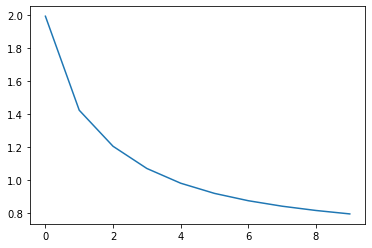

In [11]:
plt.plot(loss_vals_epochs, label="training loss")


## Evaluation

In [12]:
#put the model back on CPU
model = model.to(device="cpu")

all_preds = []
all_targets = []

ds_elems = [ds_train[i] for i in range(max_events_train, max_events_train + max_events_eval)]

# Define batch size
batch_size = 32  
for i in range(0, len(ds_elems), batch_size):
    batch_elems = ds_elems[i:i + batch_size]

    # input features
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in batch_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)

    #  target labels
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in batch_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)

    #  mask for the batch
    mask = X_features_padded[:, :, 0] != 0

    #  model prediction, loss computation
    preds = model(X_features_padded, mask)
    preds = preds[0].detach(), preds[1].detach()

    # Update mask for the batch
    mask = X_features_padded[:, :, 0] != 0

    # Unpack predictions and targets for the batch
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    
    # append to a list 
    all_preds.append(preds_unpacked)
    all_targets.append(targets_unpacked)
    
    

    # Compute loss for the batch
    loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)

 

In [13]:
loss

{'Classification': tensor(0.5378),
 'Regression': tensor(0.2856),
 'MET': tensor(11.9503),
 'Total': tensor(0.8234)}

In [14]:
pt = [data['pt'] for data in all_preds]
# pt

In [15]:
# ds_elems = [ds_train[i] for i in range(max_events_train,max_events_train+max_events_eval)]
# X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
# X_features_padded = pad_sequence(X_features, batch_first=True)
# y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
# y_targets_padded = pad_sequence(y_targets, batch_first=True)
# mask = X_features_padded[:, :, 0]!=0

In [16]:
# preds = model(X_features_padded, mask)
# preds = preds[0].detach(), preds[1].detach()
# mask = X_features_padded[:, :, 0:1] != 0
# preds_unpacked = unpack_predictions(preds)
# targets_unpacked = unpack_target(y_targets_padded)

# loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)

In [17]:
msk_true_particles = targets_unpacked["cls_id"]!=0

pt_target = targets_unpacked["pt"][msk_true_particles].numpy()
pt_pred = preds_unpacked["pt"][msk_true_particles].numpy()

eta_target = targets_unpacked["eta"][msk_true_particles].numpy()
eta_pred = preds_unpacked["eta"][msk_true_particles].numpy()

sphi_target = targets_unpacked["sin_phi"][msk_true_particles].numpy()
sphi_pred = preds_unpacked["sin_phi"][msk_true_particles].numpy()

cphi_target = targets_unpacked["cos_phi"][msk_true_particles].numpy()
cphi_pred = preds_unpacked["cos_phi"][msk_true_particles].numpy()

energy_target = targets_unpacked["energy"][msk_true_particles].numpy()
energy_pred = preds_unpacked["energy"][msk_true_particles].numpy()

px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_true_particles
py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_true_particles
pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

px = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

Text(0, 0.5, 'pred MET')

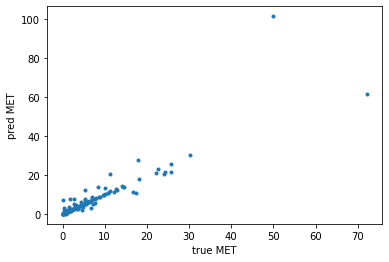

In [18]:
plt.scatter(true_met, pred_met, marker=".")
plt.xlabel("true MET")
plt.ylabel("pred MET")

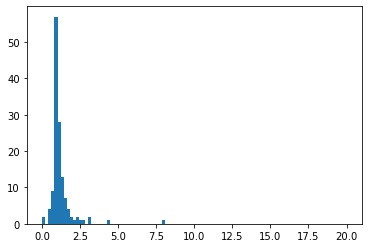

In [19]:
plt.hist(pred_met/true_met, bins=np.linspace(0,20,100));

Text(0, 0.5, 'pred pt')

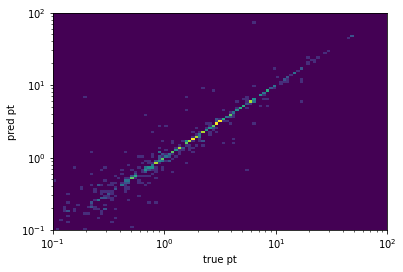

In [20]:
b = np.logspace(-1,2,100)
plt.hist2d(
    pt_target,
    pt_pred,
    bins=(b,b)
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("true pt")
plt.ylabel("pred pt")

Text(0, 0.5, 'pred eta')

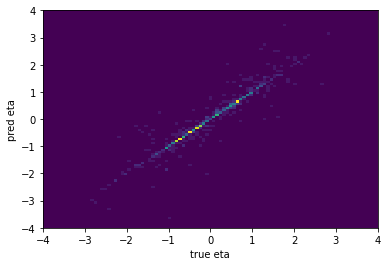

In [21]:
b = np.linspace(-4,4,100)
plt.hist2d(
    eta_target,
    eta_pred,
    bins=(b,b)
)
plt.xlabel("true eta")
plt.ylabel("pred eta")

Text(0, 0.5, 'pred sphi')

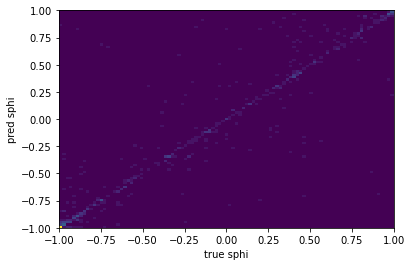

In [22]:
b = np.linspace(-1,1,100)
plt.hist2d(
    sphi_target,
    sphi_pred,
    bins=(b,b)
)
plt.xlabel("true sphi")
plt.ylabel("pred sphi")

Text(0, 0.5, 'pred cphi')

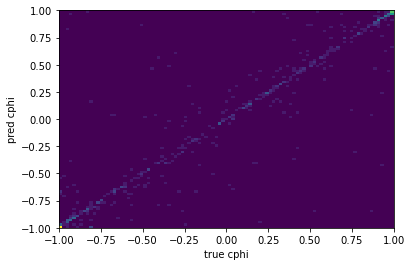

In [23]:
b = np.linspace(-1,1,100)
plt.hist2d(
    cphi_target,
    cphi_pred,
    bins=(b,b)
)
plt.xlabel("true cphi")
plt.ylabel("pred cphi")

Text(0, 0.5, 'pred energy')

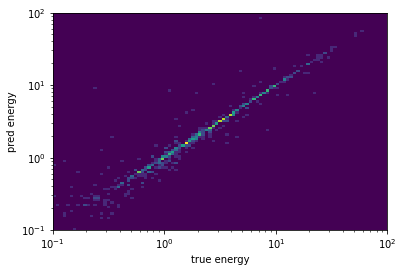

In [24]:
b = np.logspace(-1,2,100)
plt.hist2d(
    energy_target,
    energy_pred,
    bins=(b,b)
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("true energy")
plt.ylabel("pred energy")

# Jets

https://fastjet.readthedocs.io/en/latest/Awkward.html

In [25]:
import fastjet as fj
import numpy as np

def create_particles(X_features):
    particles = []
    for x_feat in X_features:
        pt, eta, phi, mass = x_feat[:, 1], x_feat[:, 2], torch.atan2(x_feat[:, 4], x_feat[:, 3]), x_feat[:, 5]
        for pt_, eta_, phi_, mass_ in zip(pt, eta, phi, mass):
            px = pt_ * torch.cos(phi_)
            py = pt_ * torch.sin(phi_)
            pz = pt_ * torch.sinh(eta_)
            e = torch.sqrt(px**2 + py**2 + pz**2 + mass_**2)
            particles.append(fj.PseudoJet(px.item(), py.item(), pz.item(), e.item()))
    return particles

# Cluster jets using FastJet
def cluster_jets(particles, R=1.0, algorithm=fj.antikt_algorithm):
    jet_def = fj.JetDefinition(algorithm, R)
    cs = fj.ClusterSequence(particles, jet_def)
    jets = fj.sorted_by_pt(cs.inclusive_jets())
    return jets


# Convert X_features into particles
particles = create_particles(X_features)

# Cluster jets
jets = cluster_jets(particles)

# Analyze jets
for i, jet in enumerate(jets):
    print(f"Jet {i+1}: pt = {jet.pt()}, eta = {jet.eta()}, phi = {jet.phi()}, mass = {jet.m()}")


Jet 1: pt = 707.9314059897632, eta = -0.22688206060131969, phi = 5.113068680217441, mass = 1231.952231367644
Jet 2: pt = 662.287664562741, eta = 0.4998694601530169, phi = 3.6214088127106288, mass = 1084.4891176510894
Jet 3: pt = 650.3448414209281, eta = 0.10290552518367481, phi = 2.277502731560636, mass = 1159.7186725080428
Jet 4: pt = 436.91384128100793, eta = -0.314101078731973, phi = 0.6295511003407852, mass = 679.6301558707829#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#   

## Quantization

In [26]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
custom_module_config = {
        "float_to_observed_custom_module_class": {torch.nn.MultiheadAttention: QuantizeableMultiheadAttention},
        "observed_to_quantized_custom_module_class": {QuantizeableMultiheadAttention: QuantizedMultiheadAttention},
}

model_prepared = torch.ao.quantization.prepare(model, prepare_custom_config_dict=custom_module_config)

#calibrate on data
num_events_to_calibrate = 5000
for ind in range(max_events_train,max_events_train+num_events_to_calibrate):
    _X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    _mask = _X[:, :, 0]!=0
    model_prepared(_X, _mask)

model_int8 = torch.ao.quantization.convert(model_prepared,convert_custom_config_dict=custom_module_config,)

/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [27]:
model_int8.quant

QuantizeFeaturesStub(
  (quants): ModuleList(
    (0): Quantize(scale=tensor([0.0157]), zero_point=tensor([0]), dtype=torch.quint8)
    (1): Quantize(scale=tensor([0.0876]), zero_point=tensor([69]), dtype=torch.quint8)
    (2): Quantize(scale=tensor([0.0797]), zero_point=tensor([63]), dtype=torch.quint8)
    (3-4): 2 x Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dtype=torch.quint8)
    (5): Quantize(scale=tensor([0.0679]), zero_point=tensor([49]), dtype=torch.quint8)
    (6): Quantize(scale=tensor([41.5642]), zero_point=tensor([78]), dtype=torch.quint8)
    (7): Quantize(scale=tensor([51.0497]), zero_point=tensor([64]), dtype=torch.quint8)
    (8): Quantize(scale=tensor([64.1927]), zero_point=tensor([64]), dtype=torch.quint8)
    (9): Quantize(scale=tensor([0.0245]), zero_point=tensor([0]), dtype=torch.quint8)
    (10): Quantize(scale=tensor([6.4767]), zero_point=tensor([0]), dtype=torch.quint8)
    (11): Quantize(scale=tensor([0.7337]), zero_point=tensor([13]), dtype=tor

In [28]:
mask_quantized = torch.quantize_per_tensor((X_features_padded[:, :, 0]!=0).to(torch.float32), 1, 0, torch.quint8)
preds = model_int8(X_features_padded, mask_quantized)
preds = preds[0].detach(), preds[1].detach()
preds_unpacked_int8 = unpack_predictions(preds)

In [29]:
loss_int8 = mlpf_loss(targets_unpacked, preds_unpacked_int8, mask)

Text(0, 0.5, 'Final total loss')

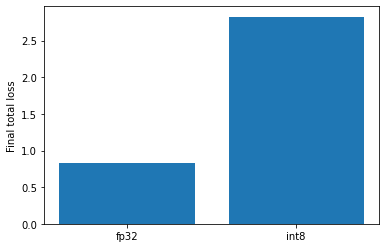

In [30]:
plt.bar(range(2), [loss["Total"].detach().numpy(), loss_int8["Total"].detach().numpy()])
plt.xticks(range(2), ["fp32", "int8"])
plt.ylabel("Final total loss")

In [31]:
pt_pred_int8 = preds_unpacked_int8["pt"][msk_true_particles].numpy()
eta_pred_int8 = preds_unpacked_int8["eta"][msk_true_particles].numpy()
sphi_pred_int8 = preds_unpacked_int8["sin_phi"][msk_true_particles].numpy()
cphi_pred_int8 = preds_unpacked_int8["cos_phi"][msk_true_particles].numpy()
energy_pred_int8 = preds_unpacked_int8["energy"][msk_true_particles].numpy()

px = preds_unpacked_int8["pt"] * preds_unpacked_int8["cos_phi"] * msk_true_particles
py = preds_unpacked_int8["pt"] * preds_unpacked_int8["sin_phi"] * msk_true_particles
pred_met_int8 = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

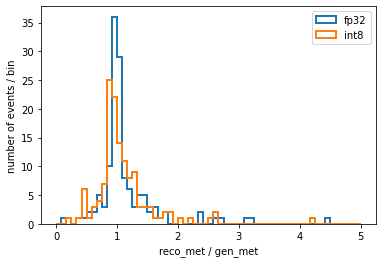

In [32]:
plt.hist(pred_met/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="fp32");
plt.hist(pred_met_int8/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="int8");
plt.xlabel("reco_met / gen_met")
plt.ylabel("number of events / bin")
plt.legend(loc="best")

In [42]:
pt_values = [jet.pt() for jet in jets]
print(f"pt_values",pt_values)

pt_values [707.9314059897632, 662.287664562741, 650.3448414209281, 436.91384128100793, 20.431037123170483, 18.36701076200816, 10.891554670557678, 8.397956325751851, 2.5134254834723624, 2.477832749018865]


In [31]:
# Define a function to predict jets using the trained model
def predict_jets(model, dataset, events_per_batch):
    predicted_jets = []
    inds = range(0, len(dataset), events_per_batch)
    for ind in tqdm.tqdm(inds):
        # Load the data for one batch
        ds_elems = dataset[ind:ind+events_per_batch]
        X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]

        # Batch the data into [batch_size, num_elems, num_features]
        X_features_padded = pad_sequence(X_features, batch_first=True).to(device=device)
        mask = X_features_padded[:, :, 0] != 0

        # Run the model to predict jets
        with torch.no_grad():
            preds = model(X_features_padded, mask)
        
        # Unpack and process the predicted jets
        preds_unpacked = unpack_predictions(preds)
        predicted_jets.extend(preds_unpacked)
    
    return predicted_jets

# Use the trained model to predict jets on the evaluation dataset
predicted_jets = predict_jets(model, ds_eval, events_per_batch)


NameError: name 'ds_eval' is not defined

In [28]:
for i, batch_elem in enumerate(X_features):
    print(f"Batch element {i}:")
    print(batch_elem)


Batch element 0:
tensor([[ 1.0000,  3.6839, -0.2448,  ..., -0.5479, -1.0000,  0.0000],
        [ 1.0000, 21.6268,  0.5386,  ...,  0.6570, -1.0000,  0.0000],
        [ 1.0000,  3.5427, -0.3341,  ...,  1.2163, -1.0000,  0.0000],
        ...,
        [ 2.0000,  1.8473, -0.5751,  ..., 25.4729, 19.2184, 18.4121],
        [ 2.0000,  0.2759, -0.0767,  ...,  5.8995,  4.7749,  2.4985],
        [ 2.0000,  0.8693, -0.6771,  ..., 30.6583, 31.6224, 28.4398]])
Batch element 1:
tensor([[ 1.0000e+00,  4.7078e+01,  2.7044e-01,  ...,  2.5455e-03,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  2.6926e+01, -6.2637e-02,  ..., -4.3941e-03,
         -1.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  2.2181e+01, -4.3668e-01,  ..., -4.4045e-03,
         -1.0000e+00,  0.0000e+00],
        ...,
        [ 2.0000e+00,  1.4925e+00, -5.4835e-01,  ...,  1.4042e+01,
          2.9127e+01,  2.4526e+01],
        [ 2.0000e+00,  2.6105e+00, -9.0993e-01,  ...,  3.6439e+01,
          4.4795e+01,  5.2597e+01],
    

In [29]:
for i, batch_elem in enumerate(X_features):
    print(f"Batch element {i} shape: {batch_elem.shape}")

Batch element 0 shape: torch.Size([122, 17])
Batch element 1 shape: torch.Size([85, 17])
Batch element 2 shape: torch.Size([93, 17])
Batch element 3 shape: torch.Size([111, 17])
Batch element 4 shape: torch.Size([112, 17])
Batch element 5 shape: torch.Size([140, 17])
Batch element 6 shape: torch.Size([124, 17])
Batch element 7 shape: torch.Size([87, 17])


In [ ]:
# for i in range(3):
#     t0 = time.time()
#     for j in range(1):
#         model(X_features_padded, X_features_padded[:, :, 0]!=0)
#     t1 = time.time()
#     print(t1 - t0)

In [ ]:
# mask_quantized = torch.quantize_per_tensor((X_features_padded[:, :, 0]!=0).to(torch.float32), 1, 0, torch.quint8)
# for i in range(3):
#     t0 = time.time()
#     for j in range(1):
#         model_int8(X_features_padded, mask_quantized)
#     t1 = time.time()
#     print(t1 - t0)

In [ ]:
export_options = torch.onnx.ExportOptions(dynamic_shapes=True)
mask = X_features_padded[:, :, 0]!=0

onnx_program = torch.onnx.dynamo_export(model, X_features_padded, mask, export_options=export_options)
onnx_program.save("mlpf_fp32_dynamo.onnx")

torch.onnx.export(model,                                            # model
                  (X_features_padded, mask),                        # model input
                  "mlpf_fp32.onnx",                                 # path
                  export_params=True,                               # store the trained parameter weights inside the model file
                  opset_version=17,                                 # the ONNX version to export the model to
                  do_constant_folding=True,                         # constant folding for optimization
                  input_names = ['input'],                          # input names
                  output_names = ['output'],                        # output names
                  dynamic_axes={'input' : {0 : 'batch_size', 1: 'num_elems'},
                                'output' : {0 : 'batch_size', 1: 'num_elems'}},
                  verbose=False)

In [ ]:
# This does not work
# onnx_program = torch.onnx.dynamo_export(model_int8, X_features_padded, mask_quantized, export_options=export_options)
# onnx_program.save("mlpf_int8_dynamo.onnx")

In [ ]:
torch.onnx.export(model_int8,                                       # model
                  (X_features_padded, mask_quantized),              # model input
                  "mlpf_int8.onnx",                                 # path
                  export_params=True,                               # store the trained parameter weights inside the model file
                  opset_version=17,                                 # the ONNX version to export the model to
                  do_constant_folding=True,                         # constant folding for optimization
                  input_names = ['input'],                          # input names
                  output_names = ['output'],                        # output names
                  dynamic_axes={'input' : {0 : 'batch_size', 1: 'num_elems'},
                                'output' : {0 : 'batch_size', 1: 'num_elems'}},
                  verbose=False)

In [ ]:
!du -csh *.onnx

In [ ]:
import onnxruntime as ort

ort_fp32 = ort.InferenceSession('mlpf_fp32.onnx')
outputs = ort_fp32.run(None, {'input': X_features_padded.numpy()})
preds_unpacked_ort_fp32 = unpack_predictions((torch.tensor(outputs[0]), torch.tensor(outputs[1])))

px = preds_unpacked_ort_fp32["pt"] * preds_unpacked_ort_fp32["cos_phi"] * msk_true_particles
py = preds_unpacked_ort_fp32["pt"] * preds_unpacked_ort_fp32["sin_phi"] * msk_true_particles
pred_met_ort_fp32 = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

ort_int8 = ort.InferenceSession('mlpf_int8.onnx')
outputs = ort_int8.run(None, {'input': X_features_padded.numpy()})
preds_unpacked_ort_int8 = unpack_predictions((torch.tensor(outputs[0]), torch.tensor(outputs[1])))

px = preds_unpacked_ort_int8["pt"] * preds_unpacked_ort_int8["cos_phi"] * msk_true_particles
py = preds_unpacked_ort_int8["pt"] * preds_unpacked_ort_int8["sin_phi"] * msk_true_particles
pred_met_ort_int8 = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

In [ ]:
plt.scatter(
    preds_unpacked["pt"][targets_unpacked["cls_id"]!=0],
    preds_unpacked_ort_fp32["pt"][targets_unpacked["cls_id"]!=0],
    marker=".", label="fp32"
)

plt.scatter(
    preds_unpacked_int8["pt"][targets_unpacked["cls_id"]!=0],
    preds_unpacked_ort_int8["pt"][targets_unpacked["cls_id"]!=0],
    marker=".", label="int8"
)
plt.xlabel("pt, pytorch")
plt.ylabel("pt, ONNX")
plt.legend(loc="best")

In [ ]:
plt.scatter(
    pred_met,
    pred_met_ort_fp32,
    marker=".", label="fp32"
)

plt.scatter(
    pred_met_int8,
    pred_met_ort_int8,
    marker=".", label="int8"
)
plt.xlabel("MET, pytorch")
plt.ylabel("MET, ONNX")
plt.legend(loc="best")